In [2]:
%matplotlib inline
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn import grid_search
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
zf = zipfile.ZipFile('./data/train_users_2.csv.zip')
df_train = pd.read_csv(zf.open('train_users_2.csv'))

zf = zipfile.ZipFile('./data/test_users.csv.zip')
df_test = pd.read_csv(zf.open('test_users.csv'))

In [4]:
zf = zipfile.ZipFile('./data/sessions.csv.zip')
df_session = pd.read_csv(zf.open('sessions.csv'))

In [5]:
zf = zipfile.ZipFile('./data/age_gender_bkts.csv.zip')
df_age_gender = pd.read_csv(zf.open('age_gender_bkts.csv'))

## Exploração dos dados


##### Juntar dados de treinamento e teste.

In [7]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

#### Dispositivo do primeiro acesso

Text(0,0.5,'Usuarios')

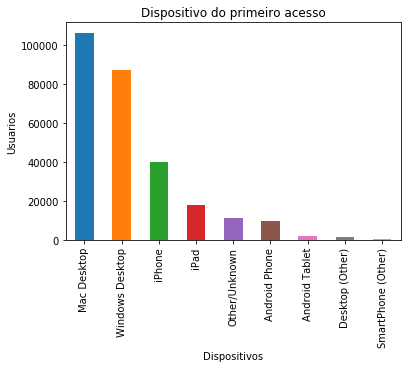

In [8]:
df_all.groupby('first_device_type').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Dispositivo do primeiro acesso')
plt.xlabel('Dispositivos')
plt.ylabel('Usuarios')

#### Forma de acesso

Text(0,0.5,'Usuarios')

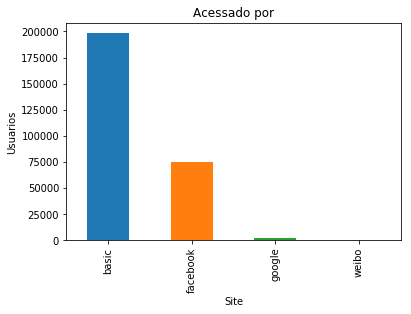

In [9]:
df_all.signup_method.value_counts().plot(kind='bar')
plt.title('Acessado por')
plt.xlabel('Site')
plt.ylabel('Usuarios')

#### Quem forneceu o acesso

Text(0.5,1,'Acesso fornecido por')

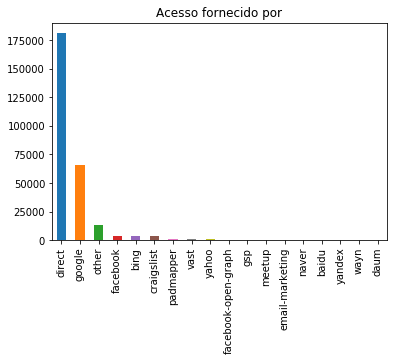

In [10]:
df_all.affiliate_provider.value_counts().plot(kind='bar')
plt.title('Acesso fornecido por')

#### Genêros em porcentagem

Text(0.5,1,'Generos')

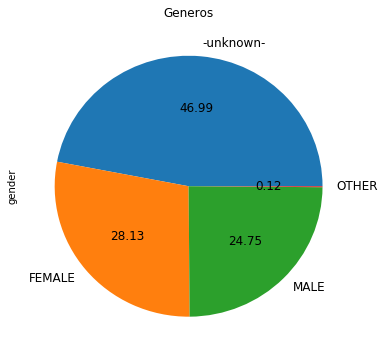

In [11]:
df_all.gender.value_counts().plot.pie(autopct='%.2f', fontsize=12, figsize=(6, 6))
plt.title('Generos')

#### Dispositivo da reserva

Text(0.5,1,'Reservas feitas com cada dispositivo')

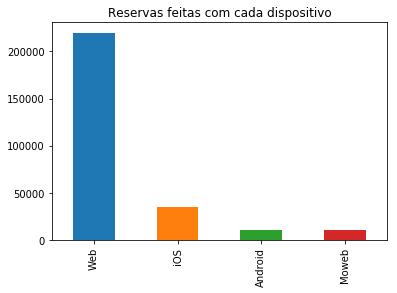

In [12]:
df_all.signup_app.value_counts().plot(kind='bar')
plt.title('Reservas feitas com cada dispositivo')

#### Idades inferiores a 18 ou superiores a 100 e inferiores 1900

In [13]:
df_all[df_all.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

In [14]:
df_all.loc[(df_all.age > 100) & (df_all.age < 1900)]['age'].describe()

count    1862.000000
mean      105.683136
std         2.461640
min       101.000000
25%       105.000000
50%       105.000000
75%       105.000000
max       150.000000
Name: age, dtype: float64

In [15]:
df_all.loc[(df_all.age > 1900) & (df_all.age < 2015)]['age'].describe()

count     828.000000
mean     2007.117150
std        22.219408
min      1920.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

#### Porcentagem de reserva em cada país

Text(0,0.5,'Porcentagem')

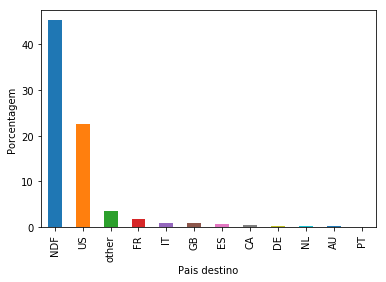

In [16]:
destination_percentage = df_all.country_destination.value_counts() / df_all.shape[0] * 100
destination_percentage.plot(kind='bar')
plt.xlabel('Pais destino')
plt.ylabel('Porcentagem')

#### Idioma faltando '-unknown-'

In [17]:
df_all.language.unique()

array(['en', 'fr', 'de', 'es', 'it', 'pt', 'zh', 'ko', 'ja', 'ru', 'pl',
       'el', 'sv', 'nl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'th', 'cs',
       'hr', 'ca', 'is', '-unknown-'], dtype=object)

#### Gênero faltando '-unknown-'

In [18]:
df_all.gender.unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

## Preparação dos dados

In [19]:
df_all.columns

Index(['affiliate_channel', 'affiliate_provider', 'age', 'country_destination',
       'date_account_created', 'date_first_booking', 'first_affiliate_tracked',
       'first_browser', 'first_device_type', 'gender', 'id', 'language',
       'signup_app', 'signup_flow', 'signup_method', 'timestamp_first_active'],
      dtype='object')

In [20]:
# Gênero faltando
df_all.gender.unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

In [21]:
df_all[df_all.gender == 'MISSING_GENDER'].shape[0]

0

### Tratamento de Idiomas

##### Substituindo gêneros "-unknown-" por "MISSING_LANGUAGE"

In [22]:
def languages(df):
    df.language.replace('-unknown-', 'MISSING_LANGUAGE', inplace=True)
    return df

In [23]:
df_all = languages(df_all)

### Tratamento de Gêneros

##### Substituindo gêneros "-unknown-" por "MISSING_GENDER"

In [24]:
def gender(df):
    df.gender.replace('-unknown-', 'MISSING_GENDER', inplace=True)
    return df

In [25]:
df_all = gender(df_all)

### Tratamento de Idades

##### Calculando idades preenchidas incorretamente. Onde foi preenchido o ano de nascimento ao invés da idade.

In [26]:
def age_calculate(df):
    user_with_year_age_mask = df['age'] > 1000
    
    # 2015 é o ano que os dados foram extraídos
    df.loc[user_with_year_age_mask, 'age'] = 2015 - df.loc[user_with_year_age_mask, 'age']
    return df    

In [27]:
df_all = age_calculate(df_all)

##### Removendo idades superiores a 100 e inferiores a 18 anos

In [28]:
def age_remove_invalids(df):
    df.loc[(df_all['age'] > 100) | (df['age'] < 18), 'age'] = -1
    df['age'].fillna(-1, inplace=True)
    return df

In [29]:
df_all = age_remove_invalids(df_all)

##### Dividindo por faixas de idade

In [30]:
def age_grouping(df):
    bins = [-1, 21, 25, 30, 35, 40, 50, 60, 75, 100]
    df['age_group'] = np.digitize(df['age'], bins, right=True)
    return df

In [31]:
df_all = age_grouping(df_all)

### Adicionando colunas sobre as sessões

In [32]:
def valid_session_number(num):
    return np.nan_to_num(num)

In [33]:
def session_features(df, df_session):
    bigger_session = df_session.groupby('user_id')['secs_elapsed'].max()
    distinct_sessions = df_session.groupby('user_id')['action'].nunique()
    num_devices = df_session.groupby('user_id')['device_type'].nunique()
    total_seconds = df_session.groupby('user_id')['secs_elapsed'].sum()
    df['total_seconds'] = df['id'].apply(lambda x: valid_session_number(total_seconds[x]) if x in total_seconds else 0)
    df['num_devices'] = df['id'].apply(lambda x: valid_session_number(num_devices[x]) if x in num_devices else 0)
    df['distinct_sessions'] = df['id'].apply(lambda x: valid_session_number(distinct_sessions[x]) if x in distinct_sessions else 0)
    df['biggest_session'] = df['id'].apply(lambda x: valid_session_number(bigger_session[x]) if x in bigger_session else 0)
    return df

### Apagando colunas

In [34]:
def remove_columns(df):
    drop_features = [
        'age',
        'date_account_created',
        'date_first_booking',
        'timestamp_first_active',
        'affiliate_provider',
        'affiliate_channel',
        'first_affiliate_tracked',
        'first_browser'
    ]
    df.drop(drop_features, axis=1, inplace=True)
    return df

In [35]:
df_all = remove_columns(df_all)

In [36]:
df_all = session_features(df_all, df_session)

### One Hot Encoding

In [37]:
def one_hot_encoding(df):
    categoricals = ['first_device_type', 'gender', 'signup_method', 'signup_flow', 'language', 'signup_app']
    df = pd.get_dummies(df, columns=categoricals, prefix='is')
    return df

In [38]:
df_all = one_hot_encoding(df_all)

In [39]:
# DF without session columns
df_all.columns

Index(['country_destination', 'id', 'age_group', 'total_seconds',
       'num_devices', 'distinct_sessions', 'biggest_session',
       'is_Android Phone', 'is_Android Tablet', 'is_Desktop (Other)',
       'is_Mac Desktop', 'is_Other/Unknown', 'is_SmartPhone (Other)',
       'is_Windows Desktop', 'is_iPad', 'is_iPhone', 'is_FEMALE', 'is_MALE',
       'is_MISSING_GENDER', 'is_OTHER', 'is_basic', 'is_facebook', 'is_google',
       'is_weibo', 'is_0', 'is_1', 'is_2', 'is_3', 'is_4', 'is_5', 'is_6',
       'is_8', 'is_10', 'is_12', 'is_14', 'is_15', 'is_16', 'is_20', 'is_21',
       'is_23', 'is_24', 'is_25', 'is_MISSING_LANGUAGE', 'is_ca', 'is_cs',
       'is_da', 'is_de', 'is_el', 'is_en', 'is_es', 'is_fi', 'is_fr', 'is_hr',
       'is_hu', 'is_id', 'is_is', 'is_it', 'is_ja', 'is_ko', 'is_nl', 'is_no',
       'is_pl', 'is_pt', 'is_ru', 'is_sv', 'is_th', 'is_tr', 'is_zh',
       'is_Android', 'is_Moweb', 'is_Web', 'is_iOS'],
      dtype='object')

##### Separa os dados de teste e de treinamento

In [40]:
df_all.set_index('id', inplace=True)
train_processed = df_all.loc[df_train['id']]
test_processed = df_all.loc[df_test['id']]

In [41]:
train_processed.shape[0]

213451

In [42]:
test_processed.shape[0]

62096

In [43]:
train_processed.columns

Index(['country_destination', 'age_group', 'total_seconds', 'num_devices',
       'distinct_sessions', 'biggest_session', 'is_Android Phone',
       'is_Android Tablet', 'is_Desktop (Other)', 'is_Mac Desktop',
       'is_Other/Unknown', 'is_SmartPhone (Other)', 'is_Windows Desktop',
       'is_iPad', 'is_iPhone', 'is_FEMALE', 'is_MALE', 'is_MISSING_GENDER',
       'is_OTHER', 'is_basic', 'is_facebook', 'is_google', 'is_weibo', 'is_0',
       'is_1', 'is_2', 'is_3', 'is_4', 'is_5', 'is_6', 'is_8', 'is_10',
       'is_12', 'is_14', 'is_15', 'is_16', 'is_20', 'is_21', 'is_23', 'is_24',
       'is_25', 'is_MISSING_LANGUAGE', 'is_ca', 'is_cs', 'is_da', 'is_de',
       'is_el', 'is_en', 'is_es', 'is_fi', 'is_fr', 'is_hr', 'is_hu', 'is_id',
       'is_is', 'is_it', 'is_ja', 'is_ko', 'is_nl', 'is_no', 'is_pl', 'is_pt',
       'is_ru', 'is_sv', 'is_th', 'is_tr', 'is_zh', 'is_Android', 'is_Moweb',
       'is_Web', 'is_iOS'],
      dtype='object')

In [44]:
y = train_processed['country_destination']
train_processed.drop(['country_destination'], axis=1, inplace=True)
X = train_processed.values

## Machine Learning

##### NDCG Scorer
A custom NDCG scorer from kaggle scripts will be used for training.

In [46]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    
    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)



#### Separando dados de treinamento e teste

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42)

### Random Forest Classifier

In [48]:
def randomForest(X, y, estimators):
    clf = RandomForestClassifier(n_estimators=estimators, random_state=101)
    parameters = {'min_samples_split': [2, 20], 'max_depth': [6, 12] }
    reg = grid_search.GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)
    reg.fit(X, y)
    est = reg.best_estimator_
    return est

In [49]:
clf = RandomForestClassifier(n_estimators=50, random_state=101)

In [50]:
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 12]}
reg = grid_search.GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)

In [52]:
reg.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 20], 'max_depth': [6, 12]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(ndcg_score, needs_proba=True, k=5), verbose=0)

In [53]:
est = reg.best_estimator_

In [54]:
print ('Random Forest:\n', metrics.classification_report(y, est.predict(X)))

Random Forest:
              precision    recall  f1-score   support

         AU       0.00      0.00      0.00       539
         CA       0.00      0.00      0.00      1428
         DE       0.00      0.00      0.00      1061
         ES       0.00      0.00      0.00      2249
         FR       0.00      0.00      0.00      5023
         GB       0.00      0.00      0.00      2324
         IT       0.00      0.00      0.00      2835
        NDF       0.62      0.95      0.75    124543
         NL       0.00      0.00      0.00       762
         PT       0.00      0.00      0.00       217
         US       0.51      0.17      0.26     62376
      other       0.00      0.00      0.00     10094

avg / total       0.51      0.61      0.51    213451



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### GradientBoostingClassifier

In [59]:
clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)  

0.631615925058548

### XGBOOST

In [309]:
est = XGBClassifier()

In [310]:
my_eval_set = [(X_train,y_train), (X_test,y_test)]
est.fit(X_train, y_train, eval_set=my_eval_set)

[0]	validation_0-merror:0.369326	validation_1-merror:0.369555
[1]	validation_0-merror:0.370497	validation_1-merror:0.370023
[2]	validation_0-merror:0.371047	validation_1-merror:0.371663
[3]	validation_0-merror:0.370445	validation_1-merror:0.371429
[4]	validation_0-merror:0.370598	validation_1-merror:0.370492
[5]	validation_0-merror:0.369948	validation_1-merror:0.370492
[6]	validation_0-merror:0.370493	validation_1-merror:0.370726
[7]	validation_0-merror:0.370081	validation_1-merror:0.37096
[8]	validation_0-merror:0.370081	validation_1-merror:0.37096
[9]	validation_0-merror:0.369073	validation_1-merror:0.368852
[10]	validation_0-merror:0.368972	validation_1-merror:0.368618
[11]	validation_0-merror:0.369054	validation_1-merror:0.368618
[12]	validation_0-merror:0.36914	validation_1-merror:0.369087
[13]	validation_0-merror:0.369087	validation_1-merror:0.368852
[14]	validation_0-merror:0.369011	validation_1-merror:0.368618
[15]	validation_0-merror:0.369011	validation_1-merror:0.368618
[16]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [311]:
ndcg_score(y_test, est.predict_proba(X_test))

0.8237697223451462

In [312]:
estOptimized = XGBClassifier(max_depth=6, learning_rate=0.25, n_estimators=50, gamma=0,
                    objective='multi:softprob', subsample=0.8, colsample_bytree=0.7, seed=101)
estOptimized.fit(X_train, y_train, eval_set=my_eval_set, early_stopping_rounds=20, eval_metric='merror')

[0]	validation_0-merror:0.379862	validation_1-merror:0.383607
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.366711	validation_1-merror:0.367682
[2]	validation_0-merror:0.365444	validation_1-merror:0.363466
[3]	validation_0-merror:0.365387	validation_1-merror:0.365808
[4]	validation_0-merror:0.364608	validation_1-merror:0.365105
[5]	validation_0-merror:0.364493	validation_1-merror:0.36534
[6]	validation_0-merror:0.364689	validation_1-merror:0.368384
[7]	validation_0-merror:0.363652	validation_1-merror:0.365574
[8]	validation_0-merror:0.363479	validation_1-merror:0.36534
[9]	validation_0-merror:0.363274	validation_1-merror:0.365574
[10]	validation_0-merror:0.363212	validation_1-merror:0.364871
[11]	validation_0-merror:0.363021	validation_1-merror:0.365105
[12]	validation_0-merror:0.362777	validation_1-merror:0.365105
[13]	validation_0-merror:0.362

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.25, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=101,
       silent=True, subsample=0.8)

In [313]:
ndcg_score(y_test, estOptimized.predict_proba(X_test))

0.8250009016031992